In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# tensorflow version
tf.__version__

'2.0.0'

loading dataset

In [3]:
path = './data/'
doc = np.load(path+'word_vec.npy', allow_pickle=True)
df = df = pd.read_csv(path+'nm_review(score_balanced).tsv', delimiter='\t', index_col=0)

In [4]:
print(f'doc.shape: {doc.shape}')
print(f'df.shape: {df.shape}')
print(f'len(doc[0]): {len(doc[0])}')
print(f'df.columns: {df.columns}')

doc.shape: (86750,)
df.shape: (86750, 7)
len(doc[0]): 8
df.columns: Index(['code', 'uid', 'datetime', 'score', 'review', 'sympathy',
       'notsympathy'],
      dtype='object')


setting random seed

In [5]:
# 랜덤시드 설정
import random
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

splitting dataset

In [6]:
from sklearn.model_selection import train_test_split

# train : test = 8 : 2
x_train, x_test, y_train, y_test = train_test_split(doc, df['score'], test_size=0.2, shuffle=True, stratify=df['score'])

print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape : {y_test.shape}')

x_train.shape: (69400,)
x_test.shape : (17350,)
y_train.shape: (69400,)
y_test.shape : (17350,)


In [7]:
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
print(f'y_train_arr.shape: {y_train_arr.shape}, type: {type(y_train_arr)}')

y_train_arr.shape: (69400,), type: <class 'numpy.ndarray'>


feature sequence processing

In [8]:
maxlen = max([len(x) for x in doc])

In [9]:
from keras.preprocessing import sequence

print('Pad sequences (samples x time)')
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen, dtype='float32', padding='post')
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen, dtype='float32', padding='post')
print('x_train_seq shape:', x_train_seq.shape)
print('x_test_seq shape:', x_test_seq.shape)

Using TensorFlow backend.


Pad sequences (samples x time)
x_train_seq shape: (69400, 60, 128)
x_test_seq shape: (17350, 60, 128)


feature scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])
for idx, item in enumerate(x_train_seq):
    x_train_seq[idx] = mms.transform(item)
for idx, item in enumerate(x_test_seq):
    x_test_seq[idx] = mms.transform(item)

label encoding

In [11]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((1e-6, 1-(1e-6)))
mms.fit([[1], [10]])
y_train_mms = mms.transform(np.array(y_train).reshape(-1, 1))
y_test_mms = mms.transform(np.array(y_test).reshape(-1, 1))
# 복구할땐 mms.inverse_transform(y_test_mms)[0]

keras modeling

In [12]:
# CNN layer
def conv_block(x, filter_nums, filter_sizes):
    """A convolution block"""
    conv_blocks = []

    for fn, fs in zip(filter_nums, filter_sizes):
        conv = tf.keras.layers.Conv1D(filters=fn,
                                      kernel_size=fs,
                                      padding='same',
                                      activation=tf.nn.relu,
                                      strides=1)(x)
        #conv = layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    return conv_blocks


# Attention layer
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

모델은 https://wikidocs.net/48920 참고해서 만들었습니다.

In [13]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Attention, Concatenate, Dropout, BatchNormalization

def create_model():
    with tf.init_scope():
        # shape [batch_size, max_tokens=60, dim=128]
        inputs = Input(shape=(60, 128))

        # CNN
        blocks = conv_block(inputs, 
                            filter_nums=(64, 64, 64, 64), 
                            filter_sizes=(1, 2, 3, 4))
        cnn_outputs = Concatenate()(blocks)
        cnn_outputs = Dropout(0.3)(cnn_outputs)

        # Bi-LSTM
        lstm_outputs, fw_h, fw_c, bw_h, bw_c = Bidirectional(
            LSTM(64,
                 dropout=0.3,
                 return_sequences=True,
                 return_state=True,
                 recurrent_activation=tf.nn.relu,
                 recurrent_initializer='glorot_uniform'))(cnn_outputs)

        state_h = Concatenate()([fw_h, bw_h]) # 은닉 상태
        # state_c = Concatenate()([fw_c, bw_c]) # 셀 상태

        # Attention
        context_vector, attention_weights = BahdanauAttention(128)(lstm_outputs, state_h)
        attn_outputs = BatchNormalization(epsilon=1e-6)(context_vector)

        # outputs
        outputs = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer='glorot_uniform')(attn_outputs)
        outputs = tf.keras.layers.Dropout(0.2, seed=42)(outputs)
        outputs = tf.keras.layers.Dense(1,
                                        kernel_initializer='glorot_uniform',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.04))(outputs)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [14]:
model = create_model()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 128)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 64)       24640       input_1[0][0]                    
______________________________________________________________________________________________

In [16]:
# optimizer
from tensorflow.keras import optimizers
RMSprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipnorm=0.5)

In [17]:
# model compile
model.compile(optimizer=RMSprop, loss='mse', metrics=['mae'])

In [18]:
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [19]:
# checkpoint
cp = tf.keras.callbacks.ModelCheckpoint(
    './model/ckpt/cnn_bilstm_bahattn_reg.ckpt', monitor='val_loss', save_best_only=True, save_weights_only=True)

In [20]:
# learn
history = model.fit(x_train_seq, y_train_mms, batch_size=256, epochs=1000, validation_split=0.2, shuffle=True,
                    callbacks=[es, cp])

Train on 55520 samples, validate on 13880 samples
Epoch 1/1000
55520/55520 [==============================] - 290s 5ms/sample - loss: 0.1204 - mae: 0.2401 - val_loss: 0.1144 - val_mae: 0.2850
Epoch 2/1000
55520/55520 [==============================] - 269s 5ms/sample - loss: 0.0666 - mae: 0.2031 - val_loss: 0.0979 - val_mae: 0.2693
Epoch 3/1000
55520/55520 [==============================] - 267s 5ms/sample - loss: 0.0615 - mae: 0.1957 - val_loss: 0.0845 - val_mae: 0.2491
Epoch 4/1000
55520/55520 [==============================] - 262s 5ms/sample - loss: 0.0592 - mae: 0.1917 - val_loss: 0.0708 - val_mae: 0.2259
Epoch 5/1000
55520/55520 [==============================] - 264s 5ms/sample - loss: 0.0576 - mae: 0.1891 - val_loss: 0.0630 - val_mae: 0.2096
Epoch 6/1000
55520/55520 [==============================] - 270s 5ms/sample - loss: 0.0565 - mae: 0.1868 - val_loss: 0.0599 - val_mae: 0.2010
Epoch 7/1000
55520/55520 [==============================] - 268s 5ms/sample - loss: 0.0555 - mae: 

In [25]:
# checkpoint load
model.load_weights('./model/ckpt/cnn_bilstm_bahattn_reg.ckpt')

evaluation

In [26]:
# 모델 평가
results = model.evaluate(x_test_seq, y_test_mms)
print('loss: {:.6f} - mae: {:.6f}'.format(*results))

17350/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss: 0.054331 - mae: 0.180802


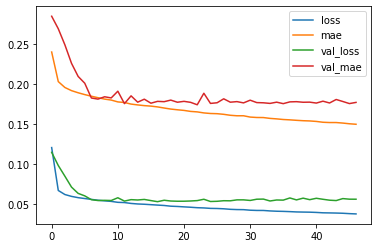

In [23]:
import matplotlib.pyplot as plt
for name, value in history.history.items():
    plt.plot(value, label=name)

plt.legend()
plt.show()

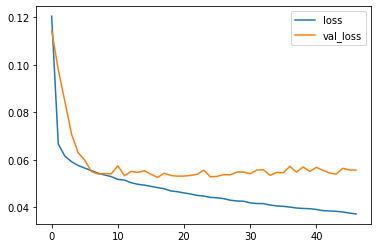

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

prediction

In [27]:
import numpy as np
from gensim.models import FastText

ft_model = FastText.load('./model/fasttext_model')

In [28]:
from hg_encoder import encode

def get_vector(query):
    query_ = encode(query)
    wv = ft_model.wv.get_vector(query_)
    return wv

In [29]:
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])

text = '기대했던만큼, 아니 그보다 더 좋았던 영화. 외로워질 때, 과거의 사랑이 떠오를 때 두고두고 이 영화가 생각날 것 같아요.'
wvs = np.array([get_vector(t) for t in text.split(' ')])
wvs = mms.transform(wvs)
wvs_seq = sequence.pad_sequences(wvs.reshape(1, wvs.shape[0], -1), maxlen=60, dtype='float32', padding='post')

In [30]:
# predict
mms = MinMaxScaler((1e-6, 1-(1e-6)))
mms.fit([[1], [10]])
print('predict score: {}'.format(mms.inverse_transform(model.predict(wvs_seq))))

predict score: [[8.257566]]


model save & load

In [31]:
# Saving model weights. (어째서인지 모델 자체의 저장이 안됨)
model.save_weights('./model/cnn_bilstm_bahattn_reg', save_format = "tf")

In [ ]:
# Loading model weights.
# 모델을 설계단계까지 진행 후 weight을 불러와야 한다.
model.load_weights('./model/cnn_bilstm_bahattn_reg')